In [18]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam


# starts from idea below


In [19]:
# Build neural network architecture
class simple_network(nn.Module):

    def __init__(self, input_size = 1):
        super().__init__()

        # network
        self.network = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)
    
# Optional

# class simple_network(nn.Module):
#     def __init__(self, input_size = 2):
#         super().__init__()
#         self.fc1 =  nn.Linear(input_size, 32)
#         self.fc2 =  nn.Tanh()
#         self.fc3 =  nn.Linear(32, 32)
#         self.fc4 =  nn.Tanh()
#         self.fc5 =  nn.Linear(32, 1)


#     def forward(self,x: torch.Tensor):
#         x = self.fc1(x)
#         x = self.fc2(x)
#         x = self.fc3(x)
#         x = self.fc4(x)
#         x = self.fc5(x) 
#         x = torch.Tensor(x)
#         return x

### Idea 

In the deep_hedge output pi+hedge where pi and hedge are neural networks. Generate price paths $S=(S_t)_{t=0}^T$ as x_train and use MSE loss with y_pred as the output model.forward(S) and y_train as $(S_T-K)^+$, value at maturity.


In [30]:
class deep_hedge_new(nn.Module):
    def __init__(self, N):
        super().__init__()

        self.N = N

        # the model will be initialized with N neural networks of type simple_network
        model = []
        parameter_list = nn.ParameterList()
        self.input_size = 1
        for i in range(N):
            temporary_model = simple_network(input_size = self.input_size)
            model.append(temporary_model)
    
            parameter_list.extend(temporary_model.parameters())

        # set model
        self.model = model

        # create list of parameters of the model
        self.parameters = parameter_list

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        s = torch.zeros_like(x[:,0])
        premium = self.model[-1](torch.tensor([0], dtype=torch.float32))
        for i in range(self.N - 1):
            hedge = self.model[i](x[:,i].unsqueeze(1).type(torch.float32))
            hedge = hedge.squeeze()
            s += hedge * (x[:,i+1] - x[:,i])
        return premium+s

In [31]:

# Generate BS price process
S0=1 # initial value of the asset
T=1 # maturity
strike = 1.0 # f(S)=(S-1)_+ European Call Contract
sigma=0.2 # volatility in Black Scholes
r = 0.0 # risk free rate
N = 100 # time disrectization
M = 10000 # number of paths
Z = np.random.normal(size=(M,N))
X = np.log(S0) * np.ones((M,N))
for i in range(N-1):
    X[:,i+1] = X[:,i] + sigma * np.sqrt(T/N) * Z[:,i] - sigma**2/2 * T/N
S = np.exp(X)
S = torch.tensor(S)
y_true = np.maximum(S[:,-1] - strike, 0)

In [33]:
# train model
model = deep_hedge_new(N)
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)
criterion = nn.MSELoss()

In [34]:
epochs = 2000

epoch_count = []
train_loss_values = []
test_loss_values = []

for epoch in range(epochs):
    model.train()
    y_pred = model.forward(S)
    loss = criterion(y_pred,y_true)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model.eval()

    if epoch % 100 == 0 and epoch > 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss)
        print(f"Epoch : {epoch}/{epochs} | Training Loss : {train_loss_values[-1]}")



Epoch : 100/1000 | Training Loss : 0.0013219056303820252
Epoch : 200/1000 | Training Loss : 0.0005897615254312448
Epoch : 300/1000 | Training Loss : 0.000489153013270745
Epoch : 400/1000 | Training Loss : 0.00045317299636400205
Epoch : 500/1000 | Training Loss : 0.0004186817332863584
Epoch : 600/1000 | Training Loss : 0.0003799274074823996
Epoch : 700/1000 | Training Loss : 0.0003371065903828032
Epoch : 800/1000 | Training Loss : 0.00029046006827249067
Epoch : 900/1000 | Training Loss : 0.0002421889928482027


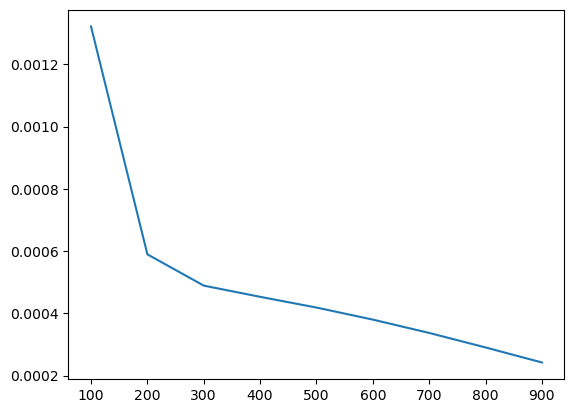

In [35]:
plt.plot(epoch_count, np.array(torch.tensor(train_loss_values).numpy()), label = 'Train loss')

In [36]:
# Generate BS price process
S0=1 # initial value of the asset
T=1 # maturity
strike = 1.0 # f(S)=(S-1)_+ European Call Contract
sigma=0.2 # volatility in Black Scholes
r = 0.0 # risk free rate
N = 100 # time disrectization
M = 10000 # number of paths
Z = np.random.normal(size=(M,N))
X = np.log(S0) * np.ones((M,N))
for i in range(N-1):
    X[:,i+1] = X[:,i] + sigma * np.sqrt(T/N) * Z[:,i] - sigma**2/2 * T/N
S = np.exp(X)
S = torch.tensor(S)

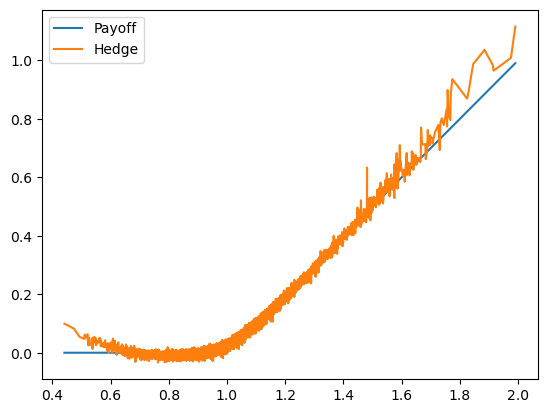

In [37]:
hedge = model.forward(S).detach().numpy()
stock = S[:,-1].detach().numpy()

I = stock.argsort()
plt.plot(stock[I], np.maximum(stock[I] - K, 0), label = "Payoff")
plt.plot(stock[I], hedge[I], label = "Hedge")
plt.legend()
plt.show()

In [38]:
payoff = torch.max(S[:,-1] - torch.tensor([strike]), torch.tensor([0]))
print(f"Price estimate : {torch.mean(payoff)}")
print(f"Price model    : {model.model[-1](torch.tensor([0], dtype=torch.float32))}")

Price estimate : 0.07898321267509119
Price model    : tensor([0.0795], grad_fn=<ViewBackward0>)


In [39]:
# time disc
T = 1
N = 100
h = T / N
M = 10000

# simulate paths in BS market: Heston model
S0 = 1
r = 0.0
rho = -0.7
alpha0 = 0.2
xi = 0.3
theta = 0.3
kappa = 2
Z = np.random.normal(size=(M, N))
W = np.random.normal(size=(M, N))
W = rho * Z + np.sqrt(1-rho**2) * W
X = np.log(S0) * np.ones((M, N))
alpha = alpha0 * np.ones((M, N))
for i in range(N-1):
    X[:,i+1] = X[:,i] + np.sqrt(alpha[:,i]) * np.sqrt(h) * Z[:,i] - alpha[:,i]/2 * h
    alpha[:,i+1] = alpha[:,i] + kappa * (theta - alpha[:,i]) * h + np.sqrt(alpha[:,i] * h) * xi * W[:,i]
S = np.exp(X)
S = torch.tensor(S)

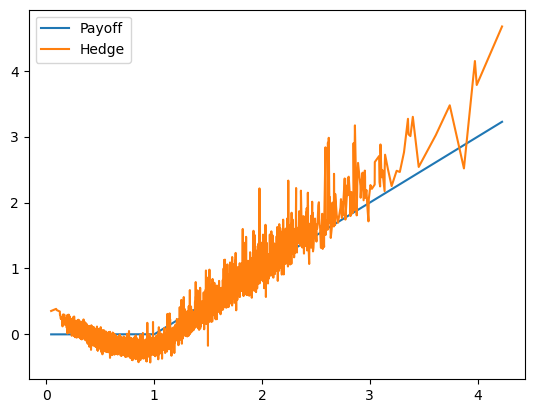

In [40]:
hedge = model.forward(S).detach().numpy()
stock = S[:,-1].detach().numpy()

I = stock.argsort()
plt.plot(stock[I], np.maximum(stock[I] - strike, 0), label = "Payoff")
plt.plot(stock[I], hedge[I], label = "Hedge")
plt.legend()
plt.show()

In [41]:
payoff = torch.max(S[:,-1] - torch.tensor([strike]), torch.tensor([0]))
print(f"Price estimate : {torch.mean(payoff)}")
print(f"Price model    : {model.model[-1](torch.tensor([0], dtype=torch.float32))}")

Price estimate : 0.1927383975751455
Price model    : tensor([0.0795], grad_fn=<ViewBackward0>)
